# Промышленность  

## Задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Подготовка данных

In [1]:
! pip install catboost

In [2]:
! pip install lightgbm

In [3]:
! pip install xgboost

In [4]:

import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


In [5]:
try: 
    data_arc = pd.read_csv('data_arc.csv')
except:
    data_arc = pd.read_csv(r'/datasets/final_steel/data_arc.csv') #  данные об электродах

In [6]:
try: 
    data_bulk = pd.read_csv('data_bulk.csv')
except:
    data_bulk = pd.read_csv(r'/datasets/final_steel/data_bulk.csv')  #  данные о подаче сыпучих материалов (объём);

In [7]:
try: 
    data_bulk_time = pd.read_csv('data_bulk_time.csv')
except:
    data_bulk_time = pd.read_csv(r'/datasets/final_steel/data_bulk_time.csv') #  данные о подаче сыпучих материалов (время);

In [8]:
try: 
    data_gas = pd.read_csv('data_gas.csv')
except:
    data_gas = pd.read_csv(r'/datasets/final_steel/data_gas.csv')  #  данные о продувке сплава газом;

In [9]:
try: 
    data_temp = pd.read_csv('data_temp.csv')
except:
    data_temp = pd.read_csv(r'/datasets/final_steel/data_temp.csv')   #   результаты измерения температуры;

In [10]:
try: 
    data_wire = pd.read_csv('data_wire.csv')
except:
    data_wire = pd.read_csv(r'/datasets/final_steel/data_wire.csv')   #   данные о проволочных материалах (объём);

In [11]:
try: 
    data_wire_time = pd.read_csv('data_wire_time.csv')
except:
    data_wire_time = pd.read_csv(r'/datasets/final_steel/data_wire_time.csv') #  данные о проволочных материалах (время).

In [12]:
data = [data_arc , data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]

In [13]:
for index in data:
    print(index.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 

Разберемся с каждой из таблиц по отдельности

### Данные об электродах

In [14]:
data_arc.head(50) # посмотрит первые 5 строк таблицы

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


Необходимо привести дату к нужному формату и привести названия столбцов "согласно правилам хорошего тона"

In [15]:
data_arc.isna().mean() # проверка на пропуски

key                     0.0
Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64

Пропусков нет

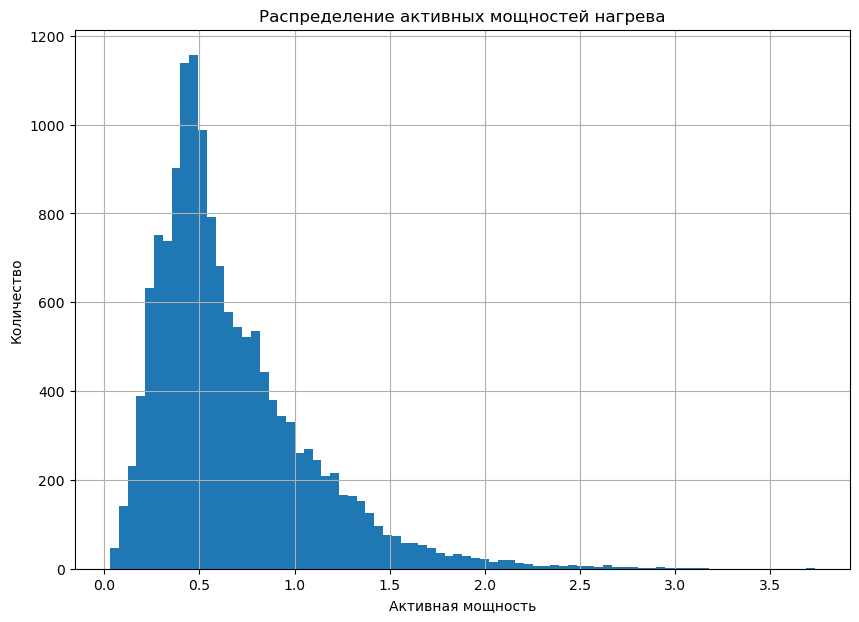

In [16]:
data_arc['Активная мощность'].hist(bins=80,figsize=(10,7)); # строим гистограмму распределния
plt.title('Распределение активных мощностей нагрева'); # название рисунка
plt.ylabel('Количество'); # подпись вертикальной оси
plt.xlabel('Активная мощность'); # подпись горизонтальной оси 

Гистограмма выглядит адекватно.

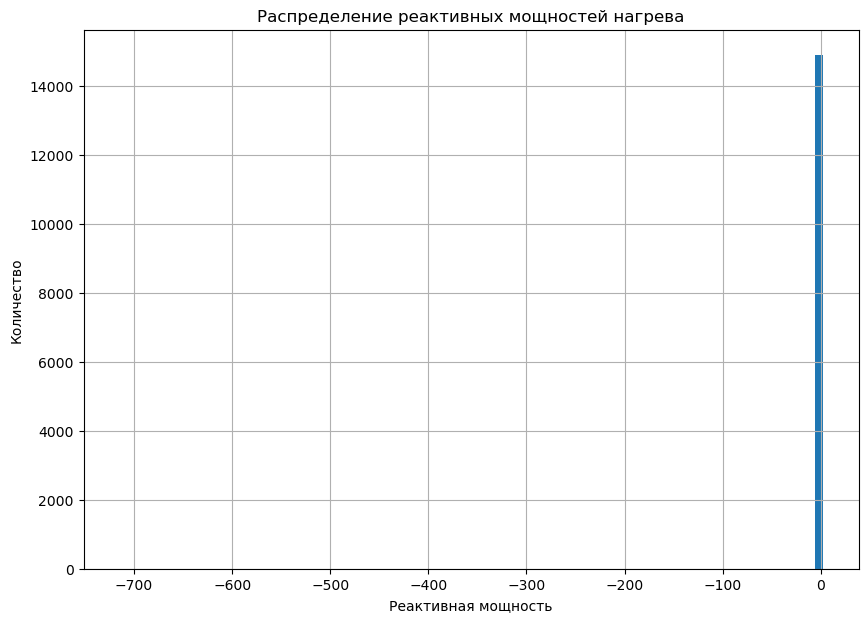

In [17]:
data_arc['Реактивная мощность'].hist(bins=80,figsize=(10,7)); # строим гистограмму распределния
plt.title('Распределение реактивных мощностей нагрева'); # название рисунка
plt.ylabel('Количество'); # подпись вертикальной оси
plt.xlabel('Реактивная мощность'); # подпись горизонтальной оси 

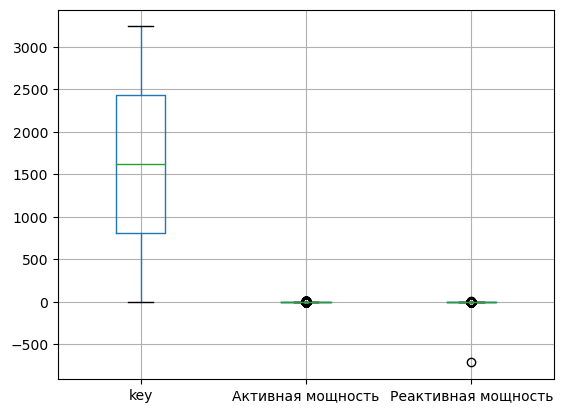

In [18]:
data_arc.boxplot(); # диаграммы распределния "ящик с усами" 

In [19]:
data_arc.sort_values(by = ['Реактивная мощность']).head() # сортировка значений по столбцу " Реактивная мощность"

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
5596,1216,2019-06-16 08:22:19,2019-06-16 08:22:30,0.030188,0.020806
2419,521,2019-05-22 17:42:57,2019-05-22 17:43:11,0.030563,0.021154
4914,1060,2019-06-11 04:31:57,2019-06-11 04:32:08,0.031630,0.022485
4633,1000,2019-06-09 01:17:44,2019-06-09 01:17:57,0.038186,0.022983


Как видим, в столбе реактивная мощность есть очевидный выброс. Остальные значения положительный

### Данные о подаче сыпучих материалов (объём)

In [20]:
data_bulk.head() # посмотрит первые 5 строк таблицы

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [21]:
data_bulk.isna().mean()  # проверка на пропуски

key        0.000000
Bulk 1     0.919463
Bulk 2     0.992969
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 5     0.975391
Bulk 6     0.815916
Bulk 7     0.992010
Bulk 8     0.999680
Bulk 9     0.993928
Bulk 10    0.943752
Bulk 11    0.943432
Bulk 12    0.217002
Bulk 13    0.994247
Bulk 14    0.103228
Bulk 15    0.281560
dtype: float64

Пропущено много значений. Видимо это связанно с тем , что добавка не вводилась, т.е. равна 0

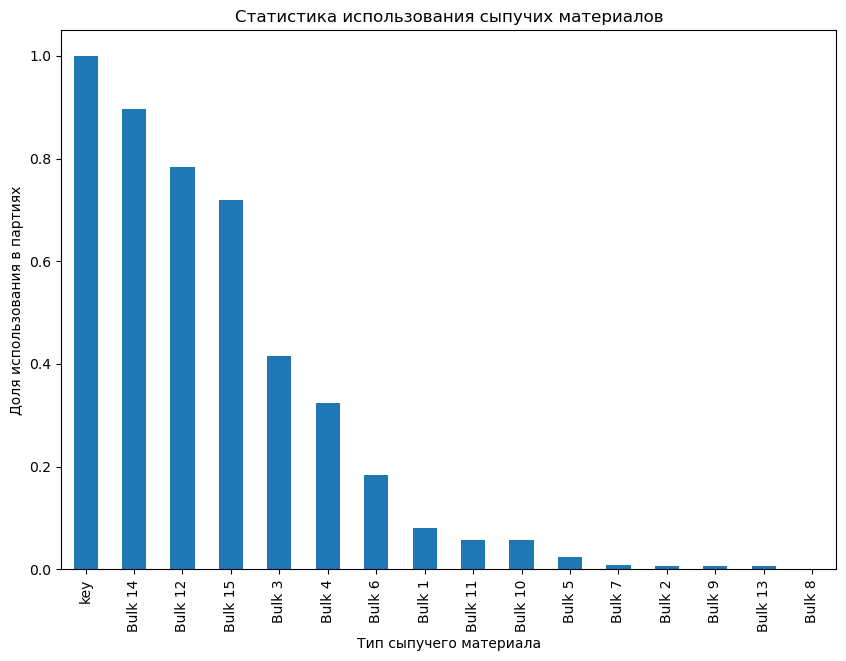

In [22]:
plt.figure(figsize = (10,7));
ax = (~data_bulk.isnull()).mean().sort_values(ascending=False).plot(kind = 'bar');
ax.set_title('Статистика использования сыпучих материалов');
ax.set_ylabel('Доля использования в партиях');
ax.set_xlabel('Тип сыпучего материала');

Очевидно разные добавки используются с разной частотой, что подтвердается графиком.

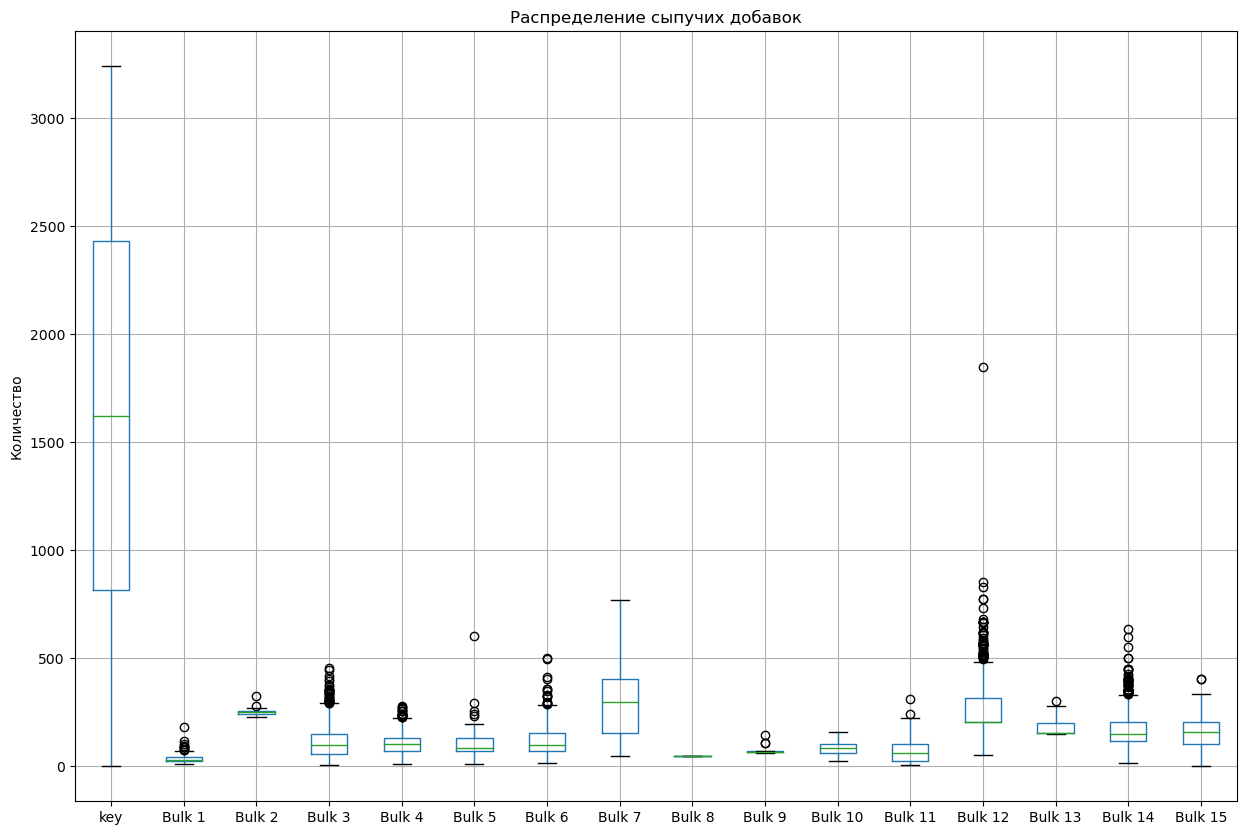

In [23]:
data_bulk.boxplot(figsize=(15,10)); # диаграммы распределния "ящик с усами" 
plt.title('Распределение сыпучих добавок'); # название рисунка
plt.ylabel('Количество'); # подпись вертикальной оси

Выбросы есть по большинсту добавок. Видимо, это связанно с несовершенством подачи добавок.

Рассмотрим 3 самые частоиспользуемые сыпучие добавки

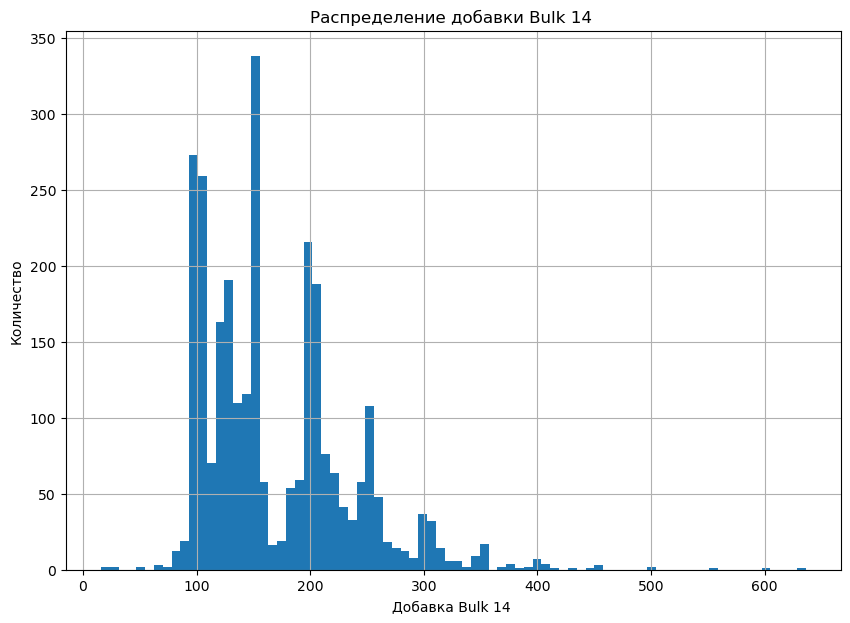

In [24]:
data_bulk['Bulk 14'].hist(bins=80,figsize=(10,7)); # строим гистограмму распределния
plt.title('Распределение добавки Bulk 14 '); # название рисунка
plt.ylabel('Количество'); # подпись вертикальной оси
plt.xlabel('Добавка Bulk 14 '); # подпись горизонтальной оси 

Можно выделить что значения распределенны около двух нормалей. Видимо, это связанно с двумя разными рецептурами для разный марок стали.

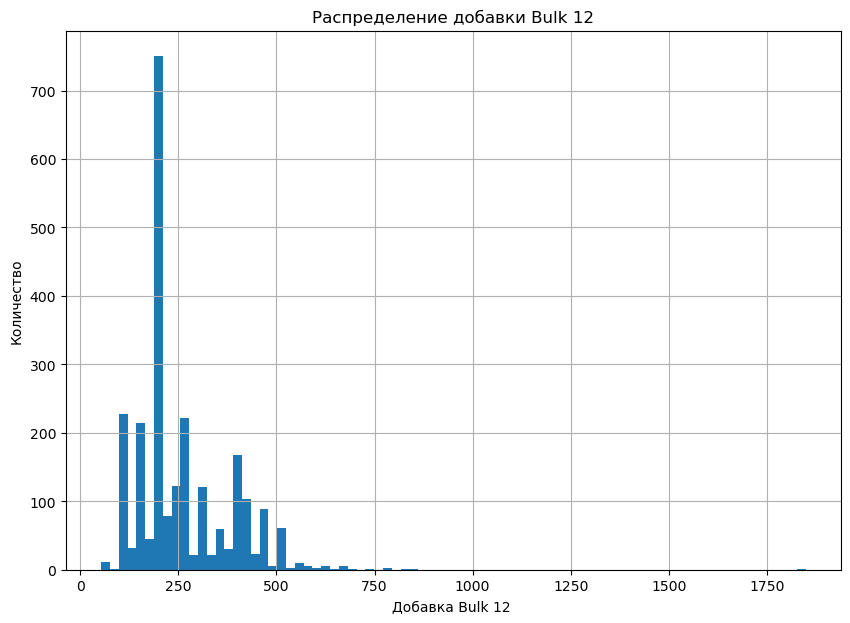

In [25]:
data_bulk['Bulk 12'].hist(bins=80,figsize=(10,7)); # строим гистограмму распределния
plt.title('Распределение добавки Bulk 12'); # название рисунка
plt.ylabel('Количество'); # подпись вертикальной оси
plt.xlabel('Добавка Bulk 12 '); # подпись горизонтальной оси 

Можно выделить что значения распределенны около двух нормалей. Видимо, это связанно с двумя разными рецептурами для разный марок стали.

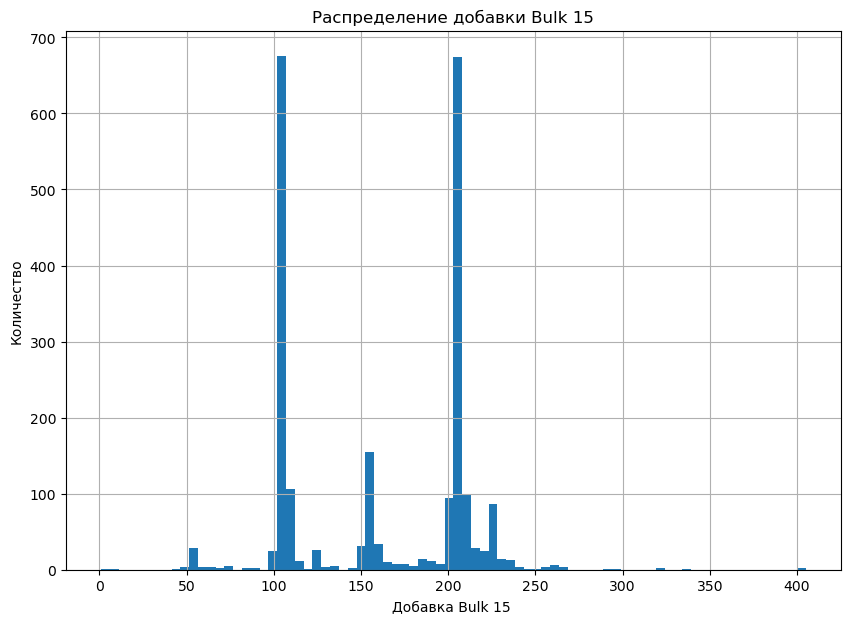

In [26]:
data_bulk['Bulk 15'].hist(bins=80,figsize=(10,7)); # строим гистограмму распределния
plt.title('Распределение добавки Bulk 15'); # название рисунка
plt.ylabel('Количество'); # подпись вертикальной оси
plt.xlabel('Добавка Bulk 15 '); # подпись горизонтальной оси 

Можно выделить что значения рааспределенны около 4 нормалей. Видимо, это связанно с 4 разными рецептурами для разный марок стали.

### Данные о подаче сыпучих материалов (время)

In [27]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [28]:
data_bulk_time.isna().mean()  # проверка на пропуски

key        0.000000
Bulk 1     0.919463
Bulk 2     0.992969
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 5     0.975391
Bulk 6     0.815916
Bulk 7     0.992010
Bulk 8     0.999680
Bulk 9     0.993928
Bulk 10    0.943752
Bulk 11    0.943432
Bulk 12    0.217002
Bulk 13    0.994247
Bulk 14    0.103228
Bulk 15    0.281560
dtype: float64

Пропущено много значений. Видимо это связанно с тем , что добавка не вводилась, т.е. равна 0

По сути, два датасета "Данные о подаче сыпучих материалов (время)" и "Данные о подаче сыпучих материалов (объем)" одинаковые таблицы с привязкой к разным параметрам

###  Данные о продувке сплава газом

In [29]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [30]:
data_gas.isna().mean()  # проверка на пропуски

key      0.0
Газ 1    0.0
dtype: float64

Пропуски отсутствуют

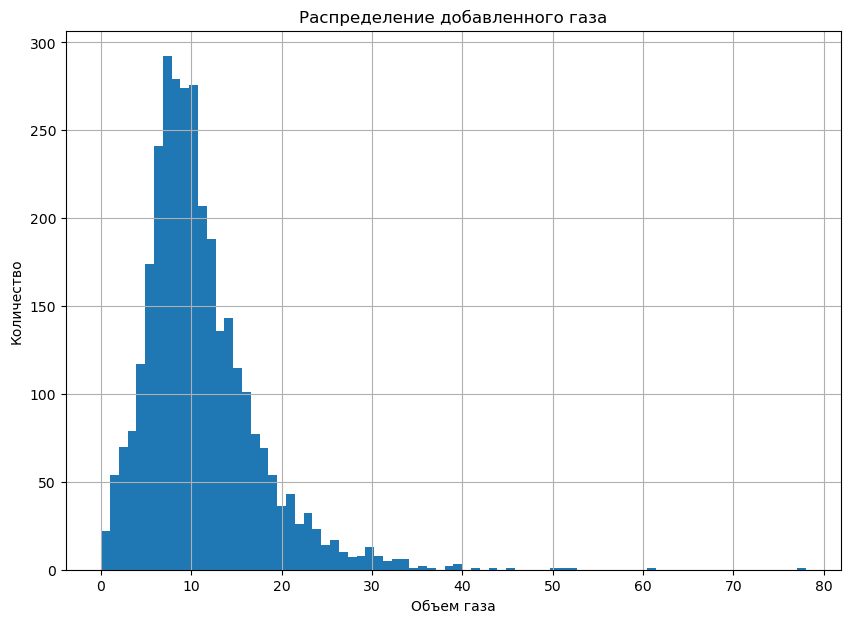

In [31]:
data_gas['Газ 1'].hist(bins=80,figsize=(10,7)); # строим гистограмму распределния
plt.title('Распределение добавленного газа'); # название рисунка
plt.ylabel('Количество'); # подпись вертикальной оси
plt.xlabel('Объем газа'); # подпись горизонтальной оси 

Распределение выглядит адекватно, но необходимо уточнить еденицы измерения.

### Результаты измерения температуры

In [32]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [33]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [34]:
data_temp.groupby(by ='key').last()

,Время замера,Температура
key,,
1,2019-05-03 11:30:39,1613.0
2,2019-05-03 11:59:12,1602.0
3,2019-05-03 12:34:57,1599.0
4,2019-05-03 12:59:25,1625.0
5,2019-05-03 13:36:01,1602.0
...,...,...
3237,2019-08-31 23:05:43,1569.0
3238,2019-08-31 23:43:00,1584.0
3239,2019-09-01 02:24:15,1598.0


In [35]:
data_temp.isna().mean()  # проверка на пропуски

key             0.000000
Время замера    0.000000
Температура     0.182373
dtype: float64

Пропущено 18.2 процента значений

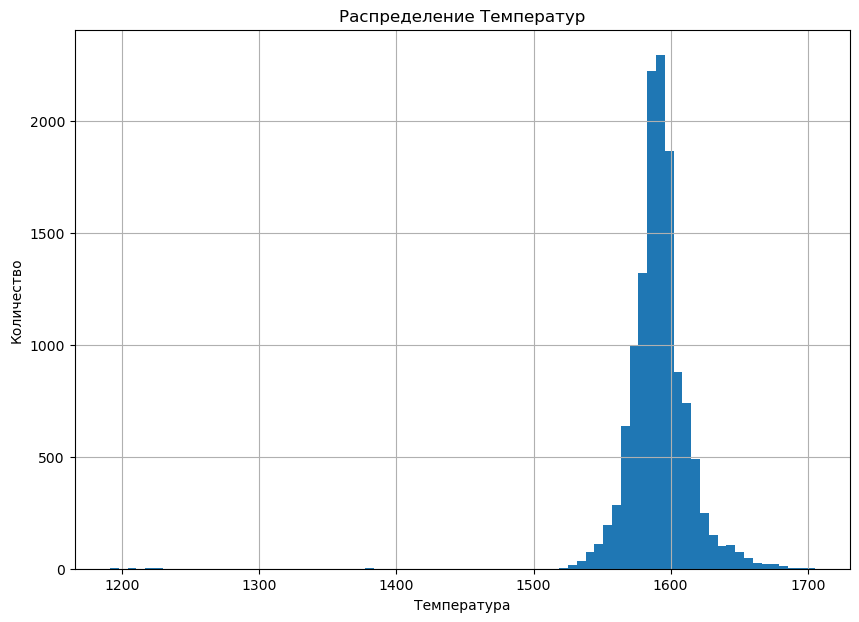

In [36]:
data_temp['Температура'].hist(bins=80,figsize=(10,7)); # строим гистограмму распределния
plt.title('Распределение Температур'); # название рисунка
plt.ylabel('Количество'); # подпись вертикальной оси
plt.xlabel('Температура'); # подпись горизонтальной оси 

Выглядит нормально за исключением того, что есть температуры ниже 1500 , что ниже температуры плавления железа

###  Данные о проволочных материалах (объём)

In [37]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
data_wire.isna().mean()  # проверка на пропуски

key       0.000000
Wire 1    0.008439
Wire 2    0.649789
Wire 3    0.979552
Wire 4    0.995456
Wire 5    0.999675
Wire 6    0.976306
Wire 7    0.996430
Wire 8    0.993833
Wire 9    0.990587
dtype: float64

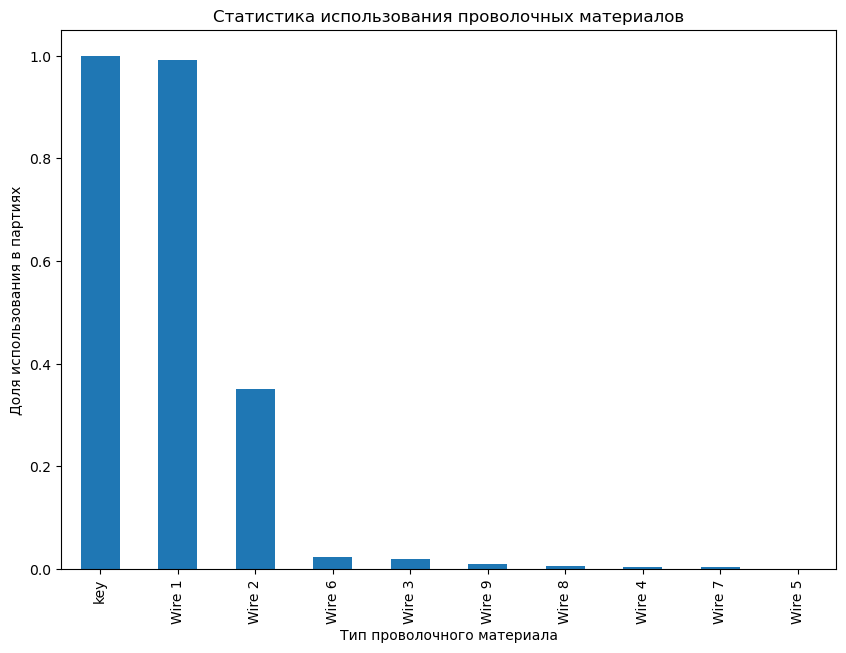

In [39]:
plt.figure(figsize = (10,7));
ax = (~data_wire.isnull()).mean().sort_values(ascending=False).plot(kind = 'bar');
ax.set_title('Статистика использования проволочных материалов');
ax.set_ylabel('Доля использования в партиях');
ax.set_xlabel('Тип проволочного материала');

Почти всегда добавляется проволочный материал Wire 1, менее чем в 40% используется проволочный материал Wire 2 , остальные материалы практически не используется.

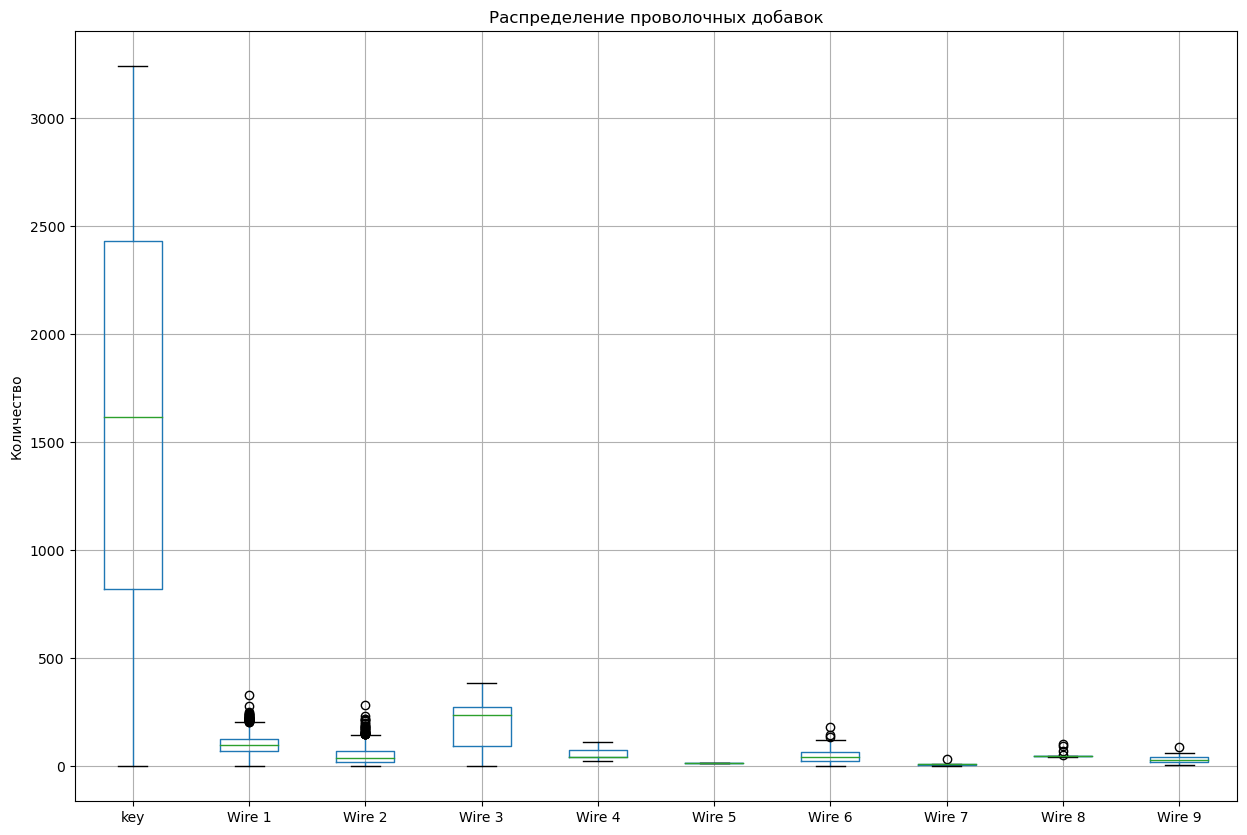

In [40]:
data_wire.boxplot(figsize=(15,10)); # диаграммы распределния "ящик с усами" 
plt.title('Распределение проволочных добавок'); # название рисунка
plt.ylabel('Количество'); # подпись вертикальной оси

Выбросы есть по большинсту проволочных добавок. Видимо, это связанно с несовершенством подачи проволочных добавок.

Рассмотрим 2 самые частоиспользуемые проволочные добавки

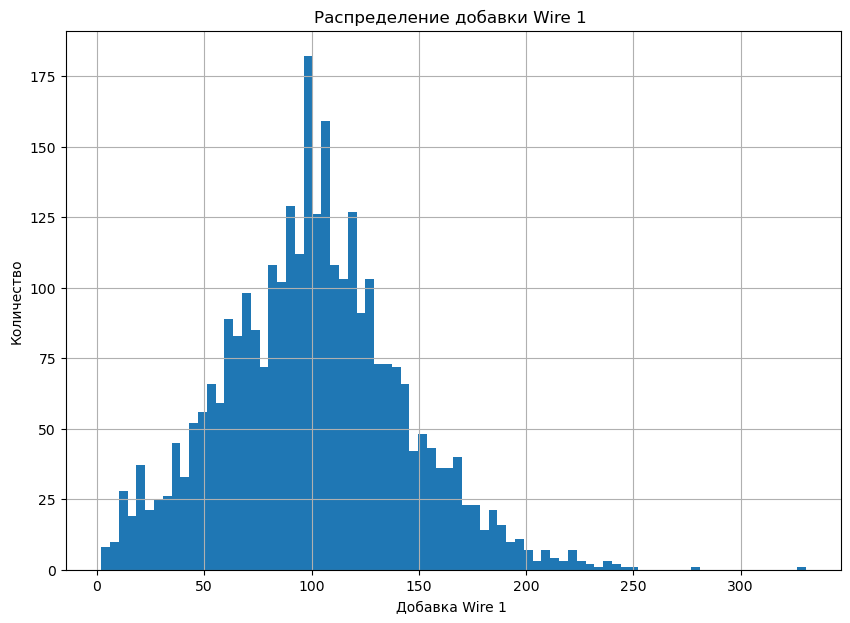

In [41]:
data_wire['Wire 1'].hist(bins=80,figsize=(10,7)); # строим гистограмму распределния
plt.title('Распределение добавки Wire 1 '); # название рисунка
plt.ylabel('Количество'); # подпись вертикальной оси
plt.xlabel('Добавка Wire 1 '); # подпись горизонтальной оси 

Распредение выглядит нормальным. С незначительными выбросами.

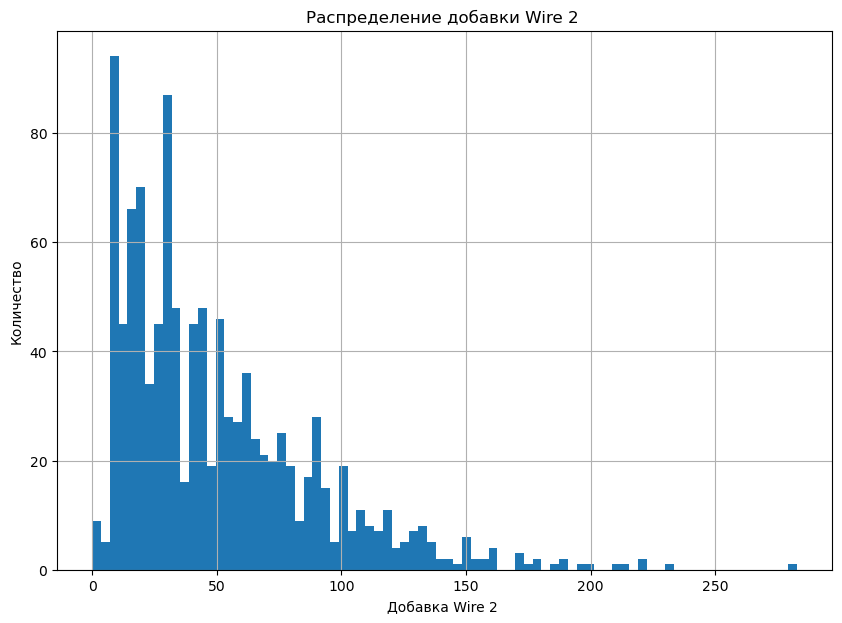

In [42]:
data_wire['Wire 2'].hist(bins=80,figsize=(10,7)); # строим гистограмму распределния
plt.title('Распределение добавки Wire 2 '); # название рисунка
plt.ylabel('Количество'); # подпись вертикальной оси
plt.xlabel('Добавка Wire 2 '); # подпись горизонтальной оси 

Распределние выглядит как распределние Пуассона, видимо, это как то связанно с особенностями технологического процесса

###  Данные о проволочных материалах (время)

In [43]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
data_wire.isna().mean()  # проверка на пропуски

key       0.000000
Wire 1    0.008439
Wire 2    0.649789
Wire 3    0.979552
Wire 4    0.995456
Wire 5    0.999675
Wire 6    0.976306
Wire 7    0.996430
Wire 8    0.993833
Wire 9    0.990587
dtype: float64

По сути, два датасета "Данные о подаче проволочных материалов (время)" и "Данные о подаче проволочных материалов (объем)" одинаковые таблицы с привязкой к разным параметрам

### Промежуточные выводы

- Временные данные не можем брать во внимание из за того , что они не корректны
- Очень много пропущенных значений в датасетах с добавками , считаем , что добавка не вводилась , то есть равна 0
- Целевой признак - конечная температура цикла нагрева
- Использовать как признак, можем только первую температуру , измеренную до процесса


### План:

* разобраться с технологическим процессом
* провести исследовательский анализ
* на основании исследовательского анализа , обработать и подготовить данные:
    - привести название столбцов к "хорошему тону"
    - заполнить пропуски
    - удалить выбросы
* формирование признаков и целевого признака     
* oбучение моделей, подбор параметров, валидация   
* выбор лучшей модели
* тестирование лучшей модели

### Вопросы

- Какие еденицы измерения газа?
- Подтверждение некорректности данных о времени
- Может ли быть отрицательная реактивная мощность?
- Подтверждение того, что пропущенные значение о добавках можем заменить на 0.
- Если на каком то этапе (цикле нагрева) пропущена температура, убираем из датасета весь цикл?


## Предобработка данных

### Данные об электродах

In [45]:
data_arc.columns=['key', 'start_heating', 'end_heating', 'active_power', 'reactive_power'] # приведем название столбцов к шрифту змеейкой

In [46]:
data_arc['start_heating'] = pd.to_datetime(data_arc['start_heating']) # трансформация значений к формату даты
data_arc['end_heating'] = pd.to_datetime(data_arc['end_heating'])# трансформация значений к формату даты
data_arc.info() # информцация о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_heating   14876 non-null  datetime64[ns]
 2   end_heating     14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


### Данные о подаче сыпучих материалов (объём)

In [47]:
data_bulk.columns=['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15'] # приведем название столбцов к шрифту змеейкой

In [48]:
data_bulk=data_bulk.fillna(value=0) # заполним отсутсвующий значения нулями

In [49]:
data_bulk

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


### Данные о подаче сыпучих материалов (время)

Не будем использовать в дальнейшем этот датасет, в связи его аналогичности датасету "Данные о подаче сыпучих материалов (объём)"

###  Данные о продувке сплава газом

In [50]:
data_gas.columns=['key', 'gas_1'] # приведем название столбцов к шрифту змеейкой

In [51]:
data_gas

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


### Результаты измерения температуры

In [52]:
data_temp.columns=['key', 'survey_time', 'temp'] # приведем название столбцов к шрифту змеейкой

In [53]:
data_temp['survey_time'] = pd.to_datetime(data_temp['survey_time']) # трансформация значений к формату даты

In [54]:
# уберем из датасета те значения 'key', где пропущенно хотя бы одно значение температур
data_temp_clean = data_temp[~data_temp['key'].isin(data_temp[data_temp['temp'].isna()]['key'].unique())]

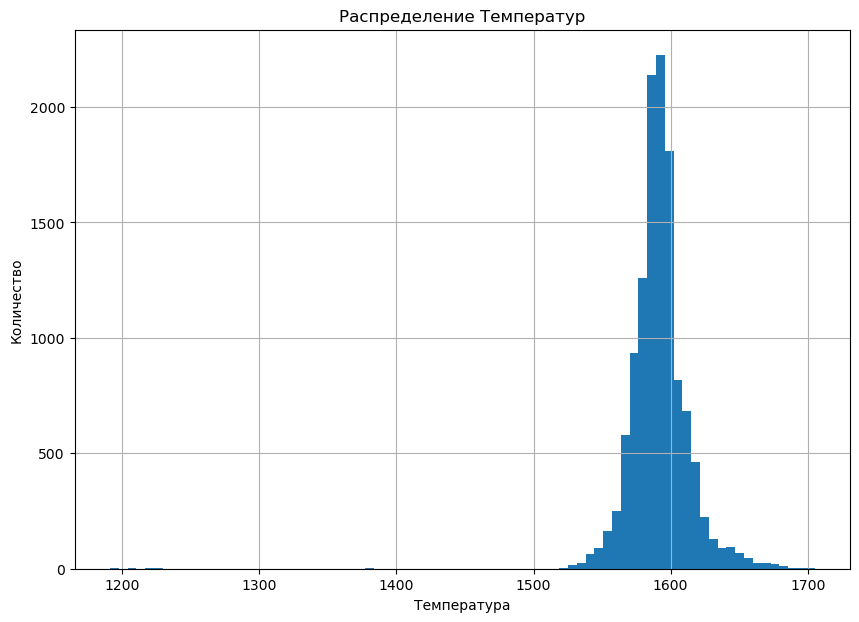

In [55]:
data_temp_clean['temp'].hist(bins=80,figsize=(10,7)); # строим гистограмму распределния
plt.title('Распределение Температур'); # название рисунка
plt.ylabel('Количество'); # подпись вертикальной оси
plt.xlabel('Температура'); # подпись горизонтальной оси 

In [56]:
data_temp_clean = data_temp_clean[data_temp_clean['temp']>1450] # уберем выбросы , значение температуры меньше 1450

###  Данные о проволочных материалах (объём)

In [57]:
data_wire.columns=['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'] # приведем название столбцов к шрифту змеейкой

In [58]:
data_wire=data_wire.fillna(value=0) # заполним отсутсвующий значения нулями

In [59]:
data_wire

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Формирование признаков

In [60]:
# cформируем таблицу с аггрегацией по "key" , в агрегируемых значения температуры будет: первая температур партии
# первая температура партии  - first temp
# последняя температура партии  - last temp


data_overall =  data_temp_clean.sort_values(by=['key' , 'survey_time'] ).groupby(by ='key').agg(first_temp =('temp','first'), last_temp=('temp','last'))

In [61]:
data_overall # вывод промежуточных результатов

,first_temp,last_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


In [62]:
# из датасета сформируем признак по разнице времени в секундах
data_arc['time_diff']= (data_arc['end_heating'] - data_arc['start_heating']).astype('timedelta64[s]')

In [63]:
data_arc

,key,start_heating,end_heating,active_power,reactive_power,time_diff
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,157.0
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,180.0
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,184.0
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,57.0


In [64]:
#data_arc['energy_per_cicle'] = data_arc['time_diff']*data_arc['active_power']

In [65]:
data_arc

,key,start_heating,end_heating,active_power,reactive_power,time_diff
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,157.0
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,180.0
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,184.0
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,57.0


In [66]:
 data_arc_agg = data_arc.groupby(by ='key').sum() # группируем значения по ключу

In [67]:
data_overall = data_overall.merge(data_arc_agg, on ='key', how = 'inner').reset_index() # присоединяем таблицы

In [68]:
data_overall # вывод промежуточных результатов

,key,first_temp,last_temp,active_power,reactive_power,time_diff
0,1,1571.0,1613.0,4.878147,3.183241,1098.0
1,2,1581.0,1602.0,3.052598,1.998112,811.0
2,3,1596.0,1599.0,2.525882,1.599076,655.0
3,4,1601.0,1625.0,3.209250,2.060298,741.0
4,5,1576.0,1602.0,3.347173,2.252643,869.0
...,...,...,...,...,...,...
2470,2495,1570.0,1591.0,3.210690,2.360777,723.0
2471,2496,1554.0,1591.0,4.203064,2.810185,940.0
2472,2497,1571.0,1589.0,2.212379,1.851269,569.0
2473,2498,1591.0,1594.0,3.408725,2.355428,750.0


In [69]:
data_overall = data_overall.merge(data_bulk, on ='key', how = 'inner')

In [70]:
data_overall = data_overall.merge(data_gas, on ='key', how = 'inner')

In [71]:
data_overall = data_overall.merge(data_wire, on ='key', how = 'inner')

In [72]:
data_overall # вывод промежуточных результатов 

,key,first_temp,last_temp,active_power,reactive_power,time_diff,bulk_1,bulk_2,bulk_3,bulk_4,...,gas_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,4.878147,3.183241,1098.0,0.0,0.0,0.0,43.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,3.052598,1.998112,811.0,0.0,0.0,0.0,73.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,2.525882,1.599076,655.0,0.0,0.0,0.0,34.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,3.209250,2.060298,741.0,0.0,0.0,0.0,81.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,3.347173,2.252643,869.0,0.0,0.0,0.0,78.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,3.210690,2.360777,723.0,0.0,0.0,21.0,0.0,...,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2325,2496,1554.0,1591.0,4.203064,2.810185,940.0,0.0,0.0,0.0,63.0,...,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2326,2497,1571.0,1589.0,2.212379,1.851269,569.0,0.0,0.0,0.0,85.0,...,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2327,2498,1591.0,1594.0,3.408725,2.355428,750.0,0.0,0.0,90.0,0.0,...,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<div class="alert alert-success">
<b>👍 Успех:</b> Датасет правильно объединен
</div>

<AxesSubplot:>

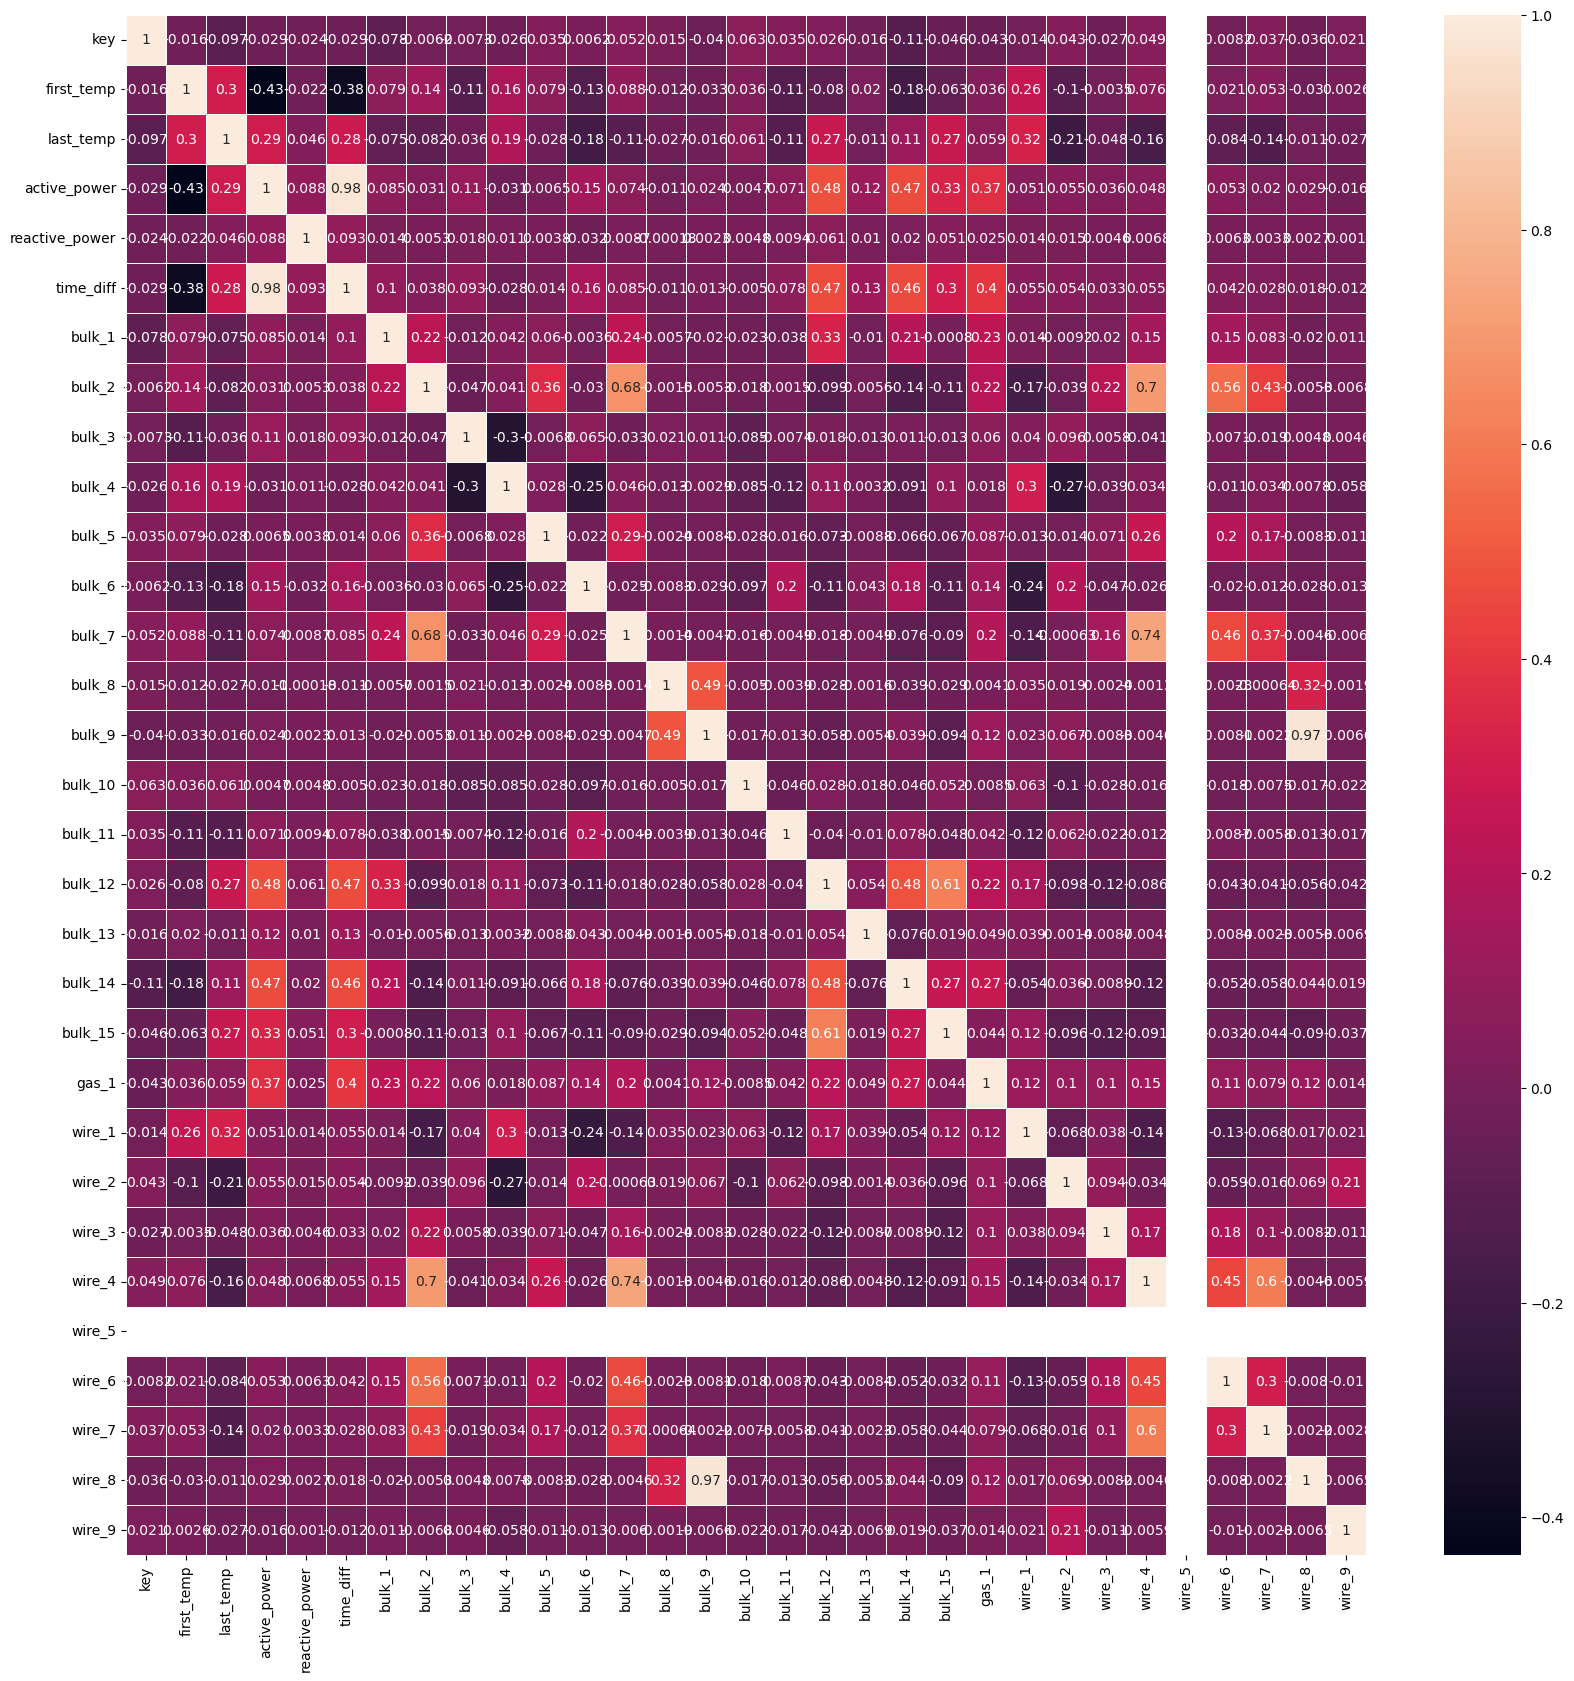

In [73]:
fig, ax = plt.subplots(figsize=(20,20))        
sns.heatmap(data_overall.corr(), annot=True, linewidths=.5, ax=ax)

Есть корреляция между active_power и time_diff , так как это связанные значения
Так же есть корреляция между некоторыми значениями wire и bulk , что видимо связанно с особенностями рецептуры
Значительной корреляции между остальными признаками нет

### Выводы

На основании исследовательского анализа , обработали и подготовили данные:
 - привели названия столбцов к "хорошему тону"
 - заполнили пропуски
 - удалить выбросы
 
Сформировали окончательную сводную таблицу для подготовки к обучению моделей
Исследовали корреляцию признаков 
Значительной корреляции между признаками нет

## Машинное обучение

### Подготовка к обучению модели

In [74]:
x = data_overall.drop(['key', 'last_temp'], axis=1) # сформируем признаки
y = data_overall['last_temp'] # сформируем целевой признак

In [75]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=3042023) # разбивка на тренировочную и тестовую выборки

In [76]:
x_train.shape # размерность тренировочной выборки 

(1746, 29)

In [77]:
y_train.shape # размерность тестовой выборки 

(1746,)

Размерности совпадают, что нам и нужно

In [78]:
def normalize(x_train, x_test):
    #  названия колонок с количественным признаком                                
    col_names = [x for x in x_train.columns]
    
    # масшатбируем модель  на тренировочной выборке                                                                            
    scaler = StandardScaler()
    scaler.fit(x_train[col_names])
    


    # преобразовываем количественные признаки                                                                            
    x_train[col_names] = scaler.transform(x_train[col_names])
    x_test[col_names] = scaler.transform(x_test[col_names])


                                                                                
    return x_train, x_test  

In [79]:

x_train, x_test = normalize(x_train, x_test) # масшатбирум признаки

In [80]:
x_train

,first_temp,active_power,reactive_power,time_diff,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,gas_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
1772,0.186729,-1.298810,-0.061253,-1.223730,-0.273921,-0.071828,0.788461,-0.639729,-0.131995,-0.408050,...,-0.511864,-0.235864,-0.508774,-0.118244,-0.067311,0.0,-0.107449,-0.035725,-0.067625,-0.078798
1300,-1.192095,0.317315,0.050527,0.526069,-0.273921,-0.071828,0.190572,-0.639729,-0.131995,-0.408050,...,-0.424217,0.375209,0.799081,-0.118244,-0.067311,0.0,-0.107449,-0.035725,-0.067625,-0.078798
1815,1.273076,-0.463147,-0.007487,-0.397848,-0.273921,-0.071828,-0.624731,-0.639729,-0.131995,1.364708,...,0.306544,-0.692632,-0.508774,-0.118244,-0.067311,0.0,-0.107449,-0.035725,-0.067625,-0.078798
981,-1.108530,0.196370,0.035785,0.026975,-0.273921,-0.071828,0.367221,-0.639729,-0.131995,-0.408050,...,-0.134731,-1.403335,-0.508774,-0.118244,-0.067311,0.0,-0.107449,-0.035725,-0.067625,-0.078798
1824,-2.403789,-0.025513,0.042967,0.062625,-0.273921,-0.071828,-0.624731,-0.639729,-0.131995,-0.408050,...,-0.151939,-2.110465,-0.508774,-0.118244,4.752390,0.0,-0.107449,-0.035725,-0.067625,-0.078798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,-0.690704,2.505814,0.280937,2.760108,-0.273921,-0.071828,-0.624731,-0.639729,-0.131995,1.592885,...,-0.738112,-1.147113,-0.508774,-0.118244,-0.067311,0.0,-0.107449,-0.035725,-0.067625,-0.078798
1705,0.312077,0.635390,0.061187,0.585485,-0.273921,-0.071828,-0.624731,-0.639729,-0.131995,-0.408050,...,-0.487612,0.895157,-0.508774,-0.118244,-0.067311,0.0,-0.107449,-0.035725,-0.067625,-0.078798
2117,-2.069529,2.131825,0.132111,1.815395,-0.273921,-0.071828,1.087406,-0.639729,-0.131995,-0.408050,...,1.793923,0.827260,-0.508774,-0.118244,-0.067311,0.0,-0.107449,-0.035725,-0.067625,-0.078798
2222,-0.314661,-0.894509,-0.038078,-0.745432,-0.273921,-0.071828,0.788461,-0.639729,-0.131995,3.628925,...,0.182216,-0.165323,-0.508774,-0.118244,-0.067311,0.0,-0.107449,-0.035725,-0.067625,-0.078798


### Линейная регрессия 

In [81]:
model_lr = LinearRegression() #  инициализация линейной регрессии 


In [82]:
scores = cross_val_score(model_lr, x_train, y_train, cv=3, scoring='neg_mean_absolute_error').mean() # кросс-валидация модели

In [83]:
print('МАЕ для  Линейной регресии:', -scores)

МАЕ для  Линейной регресии: 8.382277288759239


### Случайный  лес - регрессор 

In [84]:
param_grid = {'n_estimators': range (10, 51, 10),
              'max_depth': range (2,8)}

In [85]:
model_rfr = RandomForestRegressor(random_state=3042023)

In [86]:
finding = GridSearchCV(model_rfr, param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=10)
finding.fit(x_train, y_train)
print('Лучшее значение MAE для случайного леса: {} при значениях гиперпараметров: {}'.format(-finding.best_score_, finding.best_params_))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START max_depth=2, n_estimators=10...............................
[CV 1/3; 1/30] END max_depth=2, n_estimators=10;, score=-7.472 total time=   0.0s
[CV 2/3; 1/30] START max_depth=2, n_estimators=10...............................
[CV 2/3; 1/30] END max_depth=2, n_estimators=10;, score=-7.442 total time=   0.0s
[CV 3/3; 1/30] START max_depth=2, n_estimators=10...............................
[CV 3/3; 1/30] END max_depth=2, n_estimators=10;, score=-7.716 total time=   0.0s
[CV 1/3; 2/30] START max_depth=2, n_estimators=20...............................
[CV 1/3; 2/30] END max_depth=2, n_estimators=20;, score=-7.307 total time=   0.0s
[CV 2/3; 2/30] START max_depth=2, n_estimators=20...............................
[CV 2/3; 2/30] END max_depth=2, n_estimators=20;, score=-7.436 total time=   0.0s
[CV 3/3; 2/30] START max_depth=2, n_estimators=20...............................
[CV 3/3; 2/30] END max_depth=2, n_estimator

### Обучение CatBoostRegressor

In [87]:
params_cb = {'n_estimators':[50, 100, 150],
             'loss_function':['MAE'],
             'max_depth':[3,4,5],
             'random_state':[3042023],
             'verbose':[False]}
model_cb = CatBoostRegressor()

In [88]:
searcher_cb = GridSearchCV(model_cb, params_cb, cv=5 , scoring='neg_mean_absolute_error')

In [89]:
%%time
searcher_cb.fit(x_train, y_train)



Wall time: 16.4 s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001CDEB65BB80>,
             param_grid={'loss_function': ['MAE'], 'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150],
                         'random_state': [3042023], 'verbose': [False]},
             scoring='neg_mean_absolute_error')

In [90]:
print('Лучшее значение MAE для  CatBoostRegressor: {} при значениях гиперпараметров: {}'.format(-searcher_cb.best_score_, searcher_cb.best_params_))

Лучшее значение MAE для  CatBoostRegressor: 6.245809001029029 при значениях гиперпараметров: {'loss_function': 'MAE', 'max_depth': 5, 'n_estimators': 150, 'random_state': 3042023, 'verbose': False}


### Обучение LightGBM

In [91]:
params_lgbm = {'n_estimators':[50, 100, 150],
               'learning_rate':[0.1, 0.01, 0.001],
               'max_depth':[3, 4, 5],
               'num_leaves':range(5,10),
               'random_state':[3042023]}
model_lgbm = LGBMRegressor()

In [92]:
searcher_lgbm = GridSearchCV(model_lgbm, params_lgbm, cv=5, scoring='neg_mean_absolute_error')

In [93]:
%%time
searcher_lgbm.fit(x_train, y_train)

Wall time: 57.1 s


GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5], 'n_estimators': [50, 100, 150],
                         'num_leaves': range(5, 10),
                         'random_state': [3042023]},
             scoring='neg_mean_absolute_error')

In [94]:
print('Лучшее значение MAE для LightGBM: {} при значениях гиперпараметров: {}'.format(-searcher_lgbm.best_score_, searcher_lgbm.best_params_))

Лучшее значение MAE для LightGBM: 6.154351393919623 при значениях гиперпараметров: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 7, 'random_state': 3042023}


### Обучение XGBoost

In [95]:
params_xgb = {'n_estimators':[50, 100, 150],
               'learning_rate':[0.1, 0.01, 0.001],
               'max_depth':[3,4,5],
               'random_state':[3042023]}
model_xgb = XGBRegressor()

In [96]:
searcher_xgb = GridSearchCV(model_xgb, params_xgb, cv=5 , scoring='neg_mean_absolute_error')

In [97]:
%%time
searcher_xgb.fit(x_train, y_train);

Wall time: 25 s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estim

In [98]:
print('Лучшее значение MAE для  XGBoost: {} при значениях гиперпараметров: {}'.format(-searcher_xgb.best_score_, searcher_xgb.best_params_))

Лучшее значение MAE для  XGBoost: 6.13912970173071 при значениях гиперпараметров: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'random_state': 3042023}


| Модель        | МАЕ           |
| ------------- | ------------- |
| Линейная регрессия  | 8.38 |
| Случайный лес - регрессор  | 6.41  |
| CatBoostRegressor  | 6.25 |
| LightGBM  | 6.15  |
| XGBoost  | 6.14 |


По результатам кросс-валидации лучшее значение МАЕ показала модель XGBoost

### Сравнение с константной моделью

In [99]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(x_train, y_train)

predictions_test = dummy_regr.predict(x_test)
print('МАЕ для тестовых данных:', mean_absolute_error(y_test, predictions_test))

МАЕ для тестовых данных: 7.702961338732591


Результат для константной модели хуже, чем у любой другой модели

### Предсказание  модели на тестовой выборке 

In [100]:
model_xgb = XGBRegressor(n_estimators =100 , learning_rate =0.1, max_depth = 4, random_state=3042023)
model_xgb.fit(x_train, y_train)
predictions_test = model_xgb.predict(x_test)
print('МАЕ для тестовых данных:', mean_absolute_error(y_test, predictions_test))

МАЕ для тестовых данных: 5.744730038258469


На тестовых данных модель XGBoost показала значение 5,74 , что выше необходимой 6,8

## Отчет по решению

### Сравнение решения и плана

#### План:

* разобраться с технологическим процессом
* провести исследовательский анализ
* на основании исследовательского анализа , обработать и подготовить данные:
    - привести название столбцов к "хорошему тону"
    - заполнить пропуски
    - удалить выбросы
* формирование признаков и целевого признака     
* oбучение моделей, подбор параметров, валидация   
* выбор лучшей модели
* тестирование лучшей модели

#### Решение


Есть некоторый объем расплавленного железа,  нагретый до определенной температуры (очевидно, выше температуры плавления) электродуговой системой нагрева (газ добавляется для создания электрической дуги)
Затем начинается очередной цикл обработки железа для получения стали ( сплава) нужной рецептуры (нужных свойств)
Задача - что бы этих циклов как можно меньше,


Провели исследовательский анализ, после чего обработали и подготовили данные

    - привели названия столбцов согласно правилам "хорошего" тона
    - заполнили пропуски нулями , так как пропущенные значения соответсвуют тому, что добавки не вводились, и удалили температуру, где отсутвовали значения
    - удалили выборосы температуры ниже температуры плавления стали
    
Затем сформиравали таблицу с признаками, выделив как целевой last_temp - последнюю температру цика.
Обучили модели Линейная регрессия , Случайный лес - регрессор, CatBoostRegressor, LightGBM, XGBoost.
Подобрали гиперпараметры и провели кросс валидацию моделей, выбрали лучшую модель и протестировали на лучшей модели.

В целом все прошло по плану, за исключением того, что потребовалось много времени , что бы детально разобраться в процессе.

### Описание трудностей проекта

Основной трудностью проекта было корректно выбрать необходимые признаки и их корректная обработка.
А так же корретно сформировать итоговый датафрейм.


 

### Признаки, которые использовали для обучения (и ихобработка)

В итоговый датафрейм вошли следующие признаки
 - last_temp - конечная температура цикла - целевой признак 
 - first_temp начальная температура для каждого цикла
 - active_power	reactive_power	- суммарные активные и реактивные мощности для каждого цикла
 - time_diff - время затраченное на каждый цикл
 - данные по сыпучим и проволочным добавкам (пропуски заполнили нулевыми значениями)

### Полное описание модели

Обучили модели Линейная регрессия , Случайный лес - регрессор, CatBoostRegressor, LightGBM, XGBoost.
и получили следующие результаты

| Модель        | МАЕ           |
| ------------- | ------------- |
| Линейная регрессия  | 8.38 |
| Случайный лес - регрессор  | 6.41  |
| CatBoostRegressor  | 6.25 |
| LightGBM  | 6.15  |
| XGBoost  | 6.14 |


Лучшую метрику МАЕ по результатам кросс-валидации показала модель XGBoost со следующими параметрами:
- learning_rate: 0.1,
- max_depth: 3,
- n_estimators: 150

Предсказание  модели на тестовой выборке 5,74 , что ниже целевой в 6,8 , в тоже время для константной модели данная мертика составила 7,7